In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import re
import os
import time
import seaborn as sb
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from numpy import nan
import math

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
W0414 15:30:41.755306 4704441792 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
stop_words = set(stopwords.words('english'))

In [3]:
dictionary = []

In [4]:
embeddings = {}

In [5]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2",trainable=True)

In [6]:
df = pd.read_csv("data/dataset/train-balanced-sarcasm.csv")

In [7]:
df_new = df[['parent_comment','comment','label']]

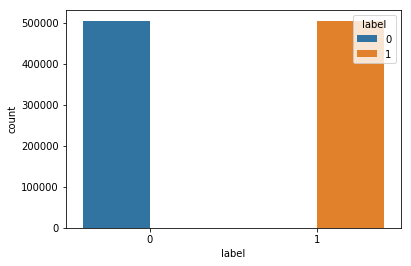

In [8]:
sb.countplot(x='label',hue='label',data=df_new)

In [9]:
df_new = df_new.sample(20000)

In [10]:
df_new.shape

(20000, 3)

In [11]:
df_new.head()

,parent_comment,comment,label
140109,I hate how they charge for ambulatory transpor...,I'm going to start moonlighting with my minivan.,0
545363,I'm just saying that in general and not talkin...,I don't know about you but I certainly would n...,0
660388,What if I told you that many progressive mille...,Yes the FCC decision (one example) really show...,1
224357,"While we are unsure of the attackers motives, ...",Imperialism,1
559023,That's kind of the problem. (And why I'm posti...,"I mean this sincerely when I say, you're one n...",0


In [12]:
def remove_stopwords(tokens):
    tokens_wo_stopwords = []
    for i in range(0,len(tokens)):
        if tokens[i].lower() not in stop_words:
            tokens_wo_stopwords.append(tokens[i].lower())
    return tokens_wo_stopwords

In [13]:
def get_pos_tag(token):
    pos_tag = nltk.pos_tag([token])[0][1]
    if pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [14]:
def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    for i in range(0,len(tokens)):
        tokens[i] = lemmatizer.lemmatize(tokens[i],pos=str(get_pos_tag(tokens[i])))
    return tokens

In [15]:
def add_to_dictionary(tokens):
    for token in tokens:
        if token not in dictionary:
            dictionary.append(token)

In [16]:
def save_dictionary():
    with open('data/processed/dictionary.txt','w') as file:
        file.writelines("%s\n" % word for word in dictionary)

In [17]:
def read_dictionary():
    with open('data/processed/dictionary.txt','r') as file:
        temp = file.read().splitlines()
        for i in range(0,len(temp)):
            dictionary.append(temp[i])

In [18]:
def save_model(sess,path):
    saver = tf.train.Saver()
    saver.save(sess,path)

In [19]:
def load_model(sess,path):
    saver = tf.train.Saver()
    saver.restore(sess,path)

In [20]:
def preprocess(sentence):
    processed_sentence = re.sub(r'[^a-zA-Z]', ' ', sentence)
    tokens_comment = word_tokenize(processed_sentence)
    tokens_comment = remove_stopwords(tokens_comment)
    tokens_comment = lemmatize(tokens_comment)
    return tokens_comment

In [21]:
def create_dictionary(dataset):
    for index,row in dataset.iterrows():
        tokens_comment = preprocess(str(row['parent_comment']) + " " + str(row['comment']))
        add_to_dictionary(tokens_comment)
    save_dictionary()

In [22]:
def populate_dictionary():
    if not os.path.isfile('data/processed/dictionary.txt'):
        starttime = time.time()
        create_dictionary(df_new)
        endtime = time.time()
        print("Time to create dictionary")
        print(endtime - starttime)
    else:   
        read_dictionary()
    print("Length of dictionary:- ")
    print(len(dictionary))

In [23]:
def populate_embeddings_dict():
    starttime = time.time()
    with open('data/processed/glove.6B.300d.txt','r') as file:
        for line in file:
            values = line.split()
            word = values[0]
            word_embedding = np.asarray(values[1:])
            embeddings[word] = word_embedding
    endtime = time.time()
    print("Time taken to load embeddings:- ")
    print(endtime - starttime)

In [24]:
def pad_tokens(tokens,max_length):
    zeros = np.zeros(len(tokens[0]))
    while len(tokens) < max_length:
        tokens = np.vstack([tokens,zeros])
    return tokens

In [25]:
def get_max_length(X):
    max_length = 0
    index = 0
    for i in range(0,len(X.index)):
        if(X[i:i+1][X.index[i]] is not nan):
            preprocessed_tokens = preprocess(X[i:i+1][X.index[i]])
            if(len(preprocessed_tokens) < 30):
                if max_length < len(preprocessed_tokens):
                    max_length = len(preprocessed_tokens)
                    index = i
    print(index)
    print(preprocess(X[index:index+1][X.index[index]]))
    return max_length

In [26]:
def embedding_lookup(x,embedding_dim=300):
    if(len(embeddings) == 0):
        populate_embeddings_dict()
    embedding = []
    for i in range(0,len(x)):
        if(x[i] in embeddings):
            embedding.append(embeddings[x[i]])
        else:
            zero_arr = np.zeros(embedding_dim).tolist()
            embedding.append(zero_arr)
    return np.array(embedding)

In [27]:
def get_elmo_embeddings(sess,tokens_input,tokens_length):
    embeddings = elmo(inputs={"tokens": tokens_input,"sequence_len": tokens_length},signature='tokens',as_dict=True)["elmo"]
    return sess.run(embeddings)

In [28]:
def get_deep_contextualized_embeddings(X,y,max_length):
    deep_contextualized_embeddings = []
    sequence_lengths = []
    elmo_tokens = []
    elmo_tokens_length = []
    elmo_embeddings_list = []
    y_pred = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        starttime = time.time()
        for i in range(0,len(X.index)):
            if(X[i:i+1][X.index[i]] is not nan):
                preprocessed_tokens = preprocess(X[i:i+1][X.index[i]])
                if(len(preprocessed_tokens) < 30):
                    sequence_lengths.append(len(preprocessed_tokens))
                    y_pred.append(y[i:i+1][y.index[i]])
                    for j in range(len(preprocessed_tokens),max_length):
                        preprocessed_tokens.append("<PAD>")
                    #word_embedding = embedding_lookup(preprocessed_tokens)
                    #word_embedding = np.array(pad_tokens(word_embedding,max_length))
                    elmo_tokens.append(preprocessed_tokens)
                    elmo_tokens_length.append(len(preprocessed_tokens))
                    #deep_contextualized_embeddings.append(np.hstack([word_embedding,elmo_embedding]))
                    if (i + 1) % 1000 == 0:
                        elmo_embedding = get_elmo_embeddings(sess,np.array(elmo_tokens),np.array(elmo_tokens_length))
                        for j in range(0,len(elmo_embedding)):
                            deep_contextualized_embeddings.append(np.array(pad_tokens(elmo_embedding[j],max_length)))
                        temp_arr = np.array(deep_contextualized_embeddings)
                        print(temp_arr.shape)
                        elmo_tokens.clear()
                        elmo_tokens_length.clear()
        endtime = time.time()
        print("Total time to generate embeddings:- ")
        print(endtime - starttime)
    return np.array(deep_contextualized_embeddings),np.array(y_pred),np.array(sequence_lengths)

In [29]:
def save_state():
    np.save('data/trained_models/generated_embeddings_train.npy',deep_contextualized_embeddings_train)
    np.save('data/trained_models/generated_embeddings_test.npy',deep_contextualized_embeddings_test)
    np.save('data/trained_models/x_train.npy',X_train)
    np.save('data/trained_models/x_test.npy',X_test)
    np.save('data/trained_models/y_train.npy',y_train)
    np.save('data/trained_models/y_test.npy',y_test)

In [30]:
#Remove nan here
X = df_new['comment']
y = df_new['label']
X.reset_index()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=222)

In [31]:
X_train.shape

(16000,)

In [32]:
X_train.index

Int64Index([370296, 201344,  16295, 770592, 995755, 842241, 801848, 342953,
            397813,  95426,
            ...
            650819, 630157, 412251, 609598, 554755, 983740, 413346, 329990,
            806189, 192020],
           dtype='int64', length=16000)

In [33]:
X_test.shape

(4000,)

In [34]:
X_test.index

Int64Index([ 95498, 367881, 655283, 460760, 913292, 815110, 306456, 823363,
            766784, 205574,
            ...
            613376, 974214, 978936, 428790, 255292, 441333, 788882, 492285,
            824284, 773190],
           dtype='int64', length=4000)

In [45]:
df_new_parent = df_new['parent_comment']
X_train_parent,X_test_parent,_,_ = train_test_split(df_new_parent,y,test_size=0.2,random_state=222)

In [49]:
X_train_parent.shape

(16000,)

In [47]:
X_train_parent.index

Int64Index([370296, 201344,  16295, 770592, 995755, 842241, 801848, 342953,
            397813,  95426,
            ...
            650819, 630157, 412251, 609598, 554755, 983740, 413346, 329990,
            806189, 192020],
           dtype='int64', length=16000)

In [50]:
X_test_parent.shape

(4000,)

In [51]:
X_test_parent.index

Int64Index([ 95498, 367881, 655283, 460760, 913292, 815110, 306456, 823363,
            766784, 205574,
            ...
            613376, 974214, 978936, 428790, 255292, 441333, 788882, 492285,
            824284, 773190],
           dtype='int64', length=4000)

In [ ]:
deep_contextualized_embeddings_train,y_pred_train,sequence_lengths_train = get_deep_contextualized_embeddings(X_train,y_train,get_max_length(X_train))

9111
['usually', 'beautiful', 'something', 'societally', 'appeal', 'rally', 'around', 'people', 'get', 'judge', 'without', 'consequence', 'enjoy', 'jealous', 'talent', 'beauty', 'fame', 'etc', 'watch', 'every', 'move', 'necessarily', 'think', 'celebrity', 'worship', 'make', 'sense', 'reason', 'popular']
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0414 15:42:10.929646 4704441792 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


In [ ]:
deep_contextualized_embeddings_parent_train,_,sequence_lengths_parent_train = get_deep_contextualized_embeddings(X_train_parent,y_train,get_max_length(X_train_parent))

In [ ]:
deep_contextualized_embeddings_test,y_pred_test,sequence_lengths_test = get_deep_contextualized_embeddings(X_test,y_test,get_max_length(X_test))

In [ ]:
deep_contextualized_embeddings_parent_test,_,sequence_lengths_parent_test = get_deep_contextualized_embeddings(X_test_parent,y_test,get_max_length(X_test_parent))

In [ ]:
deep_contextualized_embeddings_train = np.array(deep_contextualized_embeddings_train)
deep_contextualized_embeddings_parent_train = np.array(deep_contextualized_embeddings_parent_train)
deep_contextualized_embeddings_test = np.array(deep_contextualized_embeddings_test)
deep_contextualized_embeddings_parent_test = np.array(deep_contextualized_embeddings_parent_test)

In [ ]:
deep_contextualized_embeddings_train.shape

In [ ]:
deep_contextualized_embeddings_parent_train.shape

In [ ]:
deep_contextualized_embeddings_test.shape

In [ ]:
deep_contextualized_embeddings_parent_test.shape

In [387]:
class LSTM():
    
    def __init__(self,num_classes,elmo_embed_size,embed_size,batch_size,epochs,init_learning_rate):
        self.X = tf.placeholder(shape=[None,None,embed_size + elmo_embed_size],dtype=tf.float32,name='X')
        self.y = tf.placeholder(shape=[None],dtype=tf.int64,name='y')
        self.sequence_lengths = tf.placeholder(shape=[None],dtype=tf.int32,name='sequence_lengths')
        self.num_classes = num_classes
        self.elmo_embed_size = elmo_embed_size
        self.embed_size = embed_size
        self.hidden_size = elmo_embed_size + embed_size
        self.batch_size = batch_size
        self.epochs = epochs
        self.init_learning_rate = init_learning_rate
        self.model()
    
    def model(self):
        cell_fw = tf.contrib.rnn.LSTMCell(self.hidden_size,forget_bias=1.0,state_is_tuple=True,reuse=tf.get_variable_scope().reuse)
        cell_bw = tf.contrib.rnn.LSTMCell(self.hidden_size,forget_bias=1.0,state_is_tuple=True,reuse=tf.get_variable_scope().reuse)
        with tf.variable_scope('Bi-Directional-LSTM',reuse=tf.AUTO_REUSE):
            output_vals,output_states = tf.nn.bidirectional_dynamic_rnn(
            cell_fw = cell_fw,
            cell_bw = cell_bw,
            inputs = self.X,
            sequence_length = self.sequence_lengths,
            dtype = tf.float32)
        self.final_state = tf.concat([output_states[0].c,output_states[1].c],axis=1)
        with tf.variable_scope('Softmax',reuse=tf.AUTO_REUSE):
            self.softmax_w = tf.get_variable('softmax_w',shape=[2 * self.hidden_size,self.num_classes],initializer=tf.truncated_normal_initializer(),dtype=tf.float32)
            self.softmax_b = tf.get_variable('softmax_b',shape=[self.num_classes],initializer=tf.constant_initializer(0.0),dtype=tf.float32)
        self.logits = tf.matmul(self.final_state,self.softmax_w) + self.softmax_b
        self.predictions = tf.argmax(tf.nn.softmax(self.logits),1,name='predictions')
        self.cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.y,logits=self.logits)
        self.cost = tf.reduce_mean(self.cross_entropy)
        self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.predictions,self.y),tf.float32),name='accuracy')
    
    def train(self,X_train,y_train,sequence_lengths_train,path):
        self.global_step = tf.Variable(0,name='global_step',trainable=False)
        self.learning_rate = tf.train.exponential_decay(self.init_learning_rate,self.global_step,8,1,staircase=True)
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        grads = optimizer.compute_gradients(self.cost)
        self.train_step = optimizer.apply_gradients(grads,global_step=self.global_step)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for j in range(0,self.epochs):
                starttime = time.time()
                epoch_cost = 0
                for i in range(0,math.ceil(X_train.shape[0]/self.batch_size)):
                    X_train_batch = X_train[i * self.batch_size : min((i + 1) * self.batch_size,X_train.shape[0])]
                    y_train_batch = y_train[i * self.batch_size : min((i + 1) * self.batch_size,len(y_train))]
                    sequence_lengths_batch = sequence_lengths_train[i * self.batch_size : min((i + 1) * self.batch_size,len(sequence_lengths_train))]
                    fetches = {
                        'cross_entropy': self.cross_entropy,
                        'cost': self.cost,
                        'train_step': self.train_step,
                        'learning_rate': self.learning_rate,
                        'global_step': self.global_step
                    }
                    feed_dict = {
                        self.X : X_train_batch,
                        self.y : y_train_batch,
                        self.sequence_lengths : sequence_lengths_batch
                    }
                    resp = sess.run(fetches,feed_dict)
                    print('Learning rate:- ')
                    print(resp['learning_rate'])
                    print('Global Step:- ')
                    print(resp['global_step'])
                    epoch_cost += resp['cost']
                endtime = time.time()
                print('Time to train epoch ' + str(j) + ':-')
                print(endtime - starttime)
                print('Epoch ' + str(j) + " cost :-")
                print(epoch_cost)
            save_model(sess,path)
            
    def test(self,X_test,y_test,sequence_lengths_test,path):
        with tf.Session() as sess:
            starttime = time.time()
            load_model(sess,path)
            fetches = {
                'accuracy': self.accuracy,
                'predictions': self.predictions
            }
            feed_dict = {
                self.X : X_test,
                self.y : y_test,
                self.sequence_lengths: sequence_lengths_test
            }
            resp = sess.run(fetches,feed_dict)
            endtime = time.time()
            print('Time to test model:- ')
            print(endtime - starttime)
            print('Model accuracy:- ')
            print(resp['accuracy'])
            print('Model predictions:- ')
            print(resp['predictions'])

In [389]:
#Hyperparameters for the model
#Hyperparameter tuning required
num_classes = 2
word_embedding_size = 0 #For now as we are currently not using Glove
elmo_embedding_size = 1024
batch_size = 1000
epochs = 10 #To be increased as the size of the dataset increases(current size being considered:- 10000 data points (8000 - Train,2000 - Test))
init_learning_rate = 0.01 #To be changed to exponentially decreasing value based on epochs passed

In [392]:
#Currenlty not using concatenation of Glove with ELMO
tf.reset_default_graph()
lstm = LSTM(num_classes,word_embedding_size,elmo_embedding_size,batch_size,epochs,init_learning_rate)

In [ ]:
lstm.train(deep_contextualized_embeddings_train,y_pred_train,sequence_lengths_train,'data/trained_models/elmo_bi_directional_lstm.ckpt')

In [ ]:
lstm.test(deep_contextualized_embeddings_test,y_pred_test,sequence_lengths_test,'data/trained_models/elmo_bi_directional_lstm.ckpt')

In [ ]:
save_state()